Author: Judit Lozano Gondolbeu

### Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve,\
                             classification_report,  accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import scikitplot as skplt

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Funciones

In [ ]:
from funciones_aux import evaluate_model, dame_matrices, matrices_threshold, dame_curvas

### Cargamos las variables

In [ ]:
with open('../data/train_ridge.pickle', 'rb') as f:
     X_train, y_train, X_test, y_test = pickle.load(f)
      # display dataset
print(X_train.head())

     C_MNTH    C_WDAY    C_HOUR    C_RCFG    C_WTHR    C_RALN    C_TRAF  \
0 -1.129054  1.375704  0.651298 -0.824320  0.948994  0.531235 -0.363466   
1 -1.129054 -0.417392 -0.779007 -0.824320 -0.246324 -0.353054 -1.353824   
2  0.183556 -0.417392 -0.646253  1.246626 -0.246324 -0.353054 -0.318034   
3  1.797639 -0.899118 -0.359585  1.246626 -0.246324 -0.353054  0.851024   
4 -1.413490 -0.504111 -0.556747 -0.605457  0.909085 -1.210185 -1.353824   

     V_TYPE    P_SAFE    V_YEAR     P_AGE     P_SEX    PP_CAR  
0 -0.251504 -0.225190 -0.118230 -0.963827  0.816670 -1.450629  
1 -0.251504 -0.225190  0.097020 -0.591176 -1.219878  0.839152  
2 -0.251504  0.074408 -0.154105 -0.692808 -1.219878  0.839152  
3 -0.711926 -0.369937  3.433395 -0.828318 -1.219878  0.174065  
4 -0.251504 -0.225190 -0.261729 -0.658931 -1.219878  0.839152  


### Modelo base (decisión al azar)

Usaremos este estimador para comparar el resultado con el de nuestros modelos más avanzados. Para que los modelos que utilizaremos posteriormente sean válidos deben alcanzar una métrica superior a la de este estimador fijándonos en la métrica de la clase minoritaria principalmente ya que es la que nos interesa predecir con mejor resultado.

In [10]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
evaluate_model(y_test, y_pred)

Accuracy of the model: 0.014567928906367404

Classification report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    773779
           1       0.01      1.00      0.03     11439

    accuracy                           0.01    785218
   macro avg       0.01      0.50      0.01    785218
weighted avg       0.00      0.01      0.00    785218


Confusion matrix: 
[[     0 773779]
 [     0  11439]]



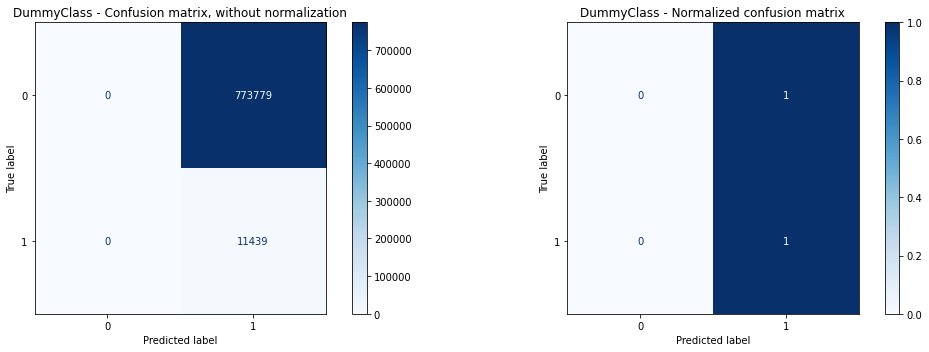

In [11]:
dame_matrices(dummy_clf)

Con este modelo 'tonto' le indicamos al algoritmo que sin tener en cuenta ningún patrón ni valor entre nuestras variables, prediga la clase minoritaria para ver en qué casos acertaría. Como observamos obtenemos una f1_score muy baja que es la que nos interesa acertar bien. Por lo tanto, este modelo nos es muy fiable e idica que la accuracy f1-score que hay que superar en los modelos más avanzado es del 3% para nuestra clase minoritaria.

### Modelos

Preparo a continuación un diccionario con la lista de modelos que quiero ir probando. No es una búsqueda exhaustiva pero me sirve para ir viendo que modelos se ajustan mejor con hiperparámetros simples pero dando más peso a la clase minoritaria para los modelos que tienen esa opción.

In [45]:
dic = {
    'GradientBoostingC': {
        'model': GradientBoostingClassifier(n_estimators=10, max_depth=1, random_state=0)
    },
    
    'Ridge': {
        'model': LogisticRegression(penalty='l2', class_weight= {0: 0.2, 1: 0.8}) 
    },
    'RandomForest': {
        'model': RandomForestClassifier(n_estimators=10, max_depth=5, class_weight= {0: 0.2, 1: 0.8})
    },

    'GaussianNB': {
        'model': GaussianNB(),
       
    },
    
    'XGBClassifier': {
        'model': xgb.XGBClassifier(n_estimators=10)
    },
    
    'LGBMClassifier': {
        'model': lgbm.LGBMClassifier(num_leaves=31, class_weight= {0: 0.2, 1: 0.8})
    }
}

In [46]:
modelres = {}
key_list= list(dic)

for i, n in zip(dic, range(len(key_list))):
    res = {}
    
    model = dic[i]['model']
    
    model.fit(X_train, y_train)
    
    with open("../data/model_"+str(key_list[n])+".pckl", "wb") as f: #me voy guardando los modelos entrenados por si quisiera trabajar con ellos más adelante
        pickle.dump(model, f)

    res['model'] = model

    res['example_params'] = model.get_params()

    res['score'] = model.score(X_test, y_test)
    
    res['roc_auc_score'] = roc_auc_score(y_true= y_test, y_score=model.predict(X_test))
    
    res['f1_score'] = f1_score(y_true= y_test, y_pred=model.predict(X_test).astype(int))

    modelres[i] = res #preparo un diccionario con los datos que me quiero guardar

[00:04:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
#me guardo los resultados en una tabla
df_res= pd.DataFrame(modelres)
df_res= df_res.T
df_res

,model,example_params,score,roc_auc_score,f1_score
GradientBoostingC,([DecisionTreeRegressor(criterion='friedman_ms...,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.985432,0.5,0.0
Ridge,"LogisticRegression(class_weight={0: 0.2, 1: 0.8})","{'C': 1.0, 'class_weight': {0: 0.2, 1: 0.8}, '...",0.783422,0.69994,0.076293
RandomForest,"(DecisionTreeClassifier(max_depth=5, max_featu...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.84691,0.657954,0.081034
GaussianNB,GaussianNB(),"{'priors': None, 'var_smoothing': 1e-09}",0.888705,0.645743,0.093821
XGBClassifier,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'objective': 'binary:logistic', 'use_label_en...",0.982444,0.524279,0.079957
LGBMClassifier,"LGBMClassifier(class_weight={0: 0.2, 1: 0.8})","{'boosting_type': 'gbdt', 'class_weight': {0: ...",0.973388,0.566581,0.13909


La curva roc representa la sensitividad (ratio de verdaderos positivos) frente a la especificidad (ratio de verdaderos negativos) segun varios umbrales. Cuanto mejor sea nuestro modelo la curva se aproximará más hacia la esquina superior izquierda de la grafica y el roc_auc_score que representa el área debajo de la curva será mas alto. 

Si observamos la roc_auc_score en la tabla de arriba nos da que el modelo LogisticRegression es el que mejor resultado obtiene. Esto tiene sentido, porque si observamos las matrices de confusión a continuación, el modelo de regresion logistica es el que tiene mejor tasa de aciertos para ambas clases que queremos predecir seguido del RandomForest.

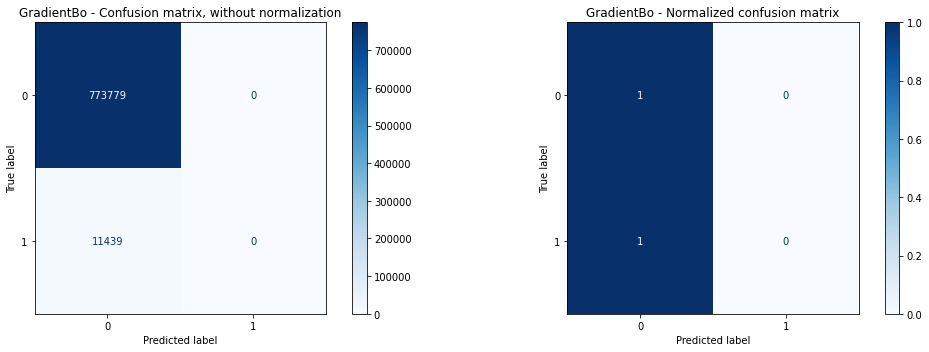

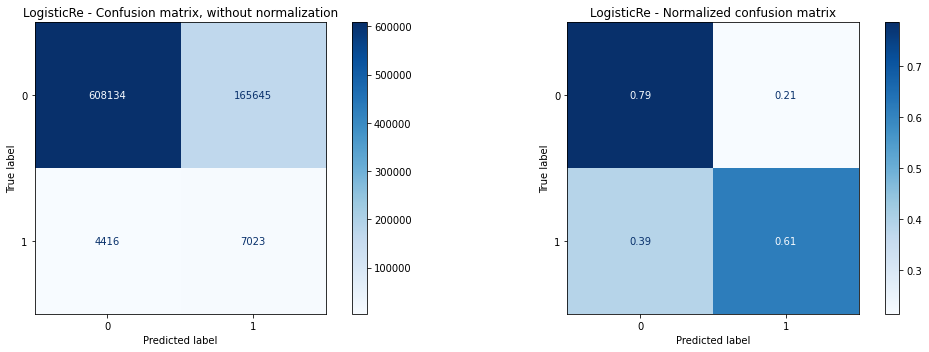

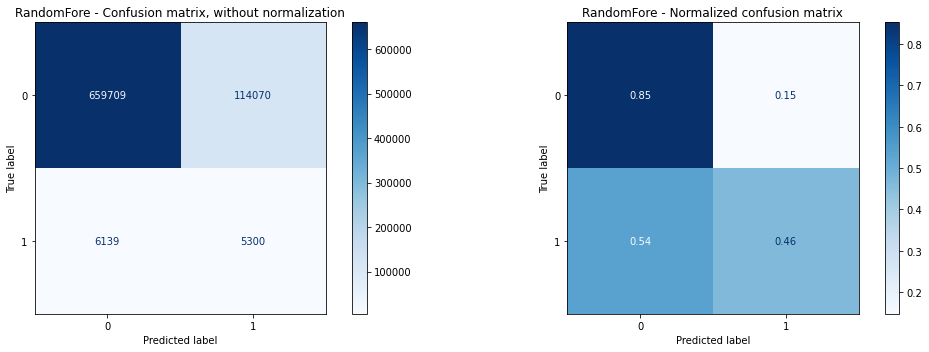

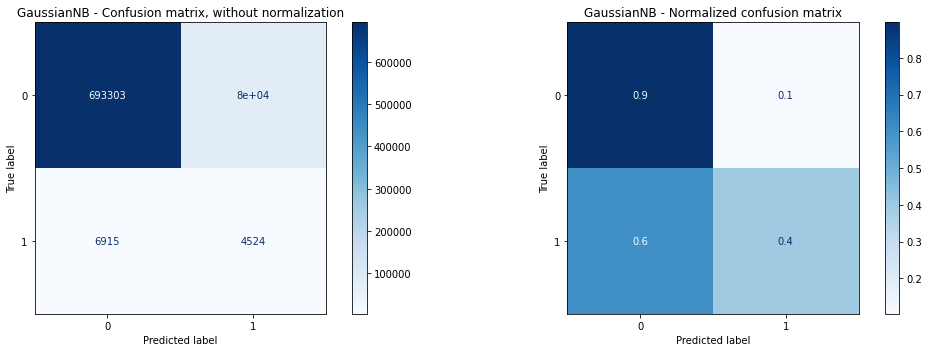

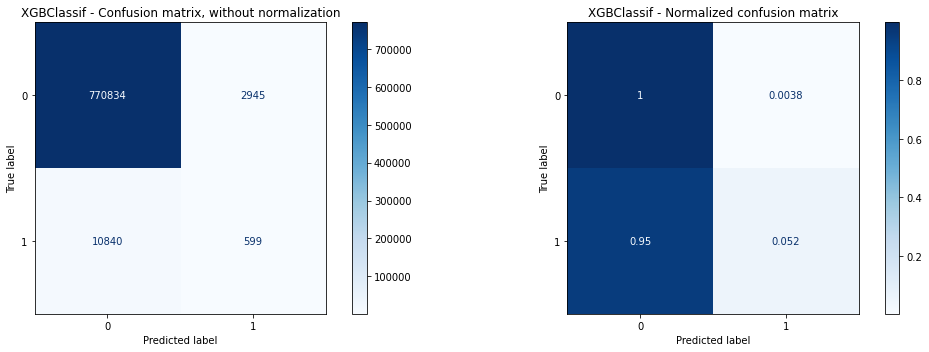

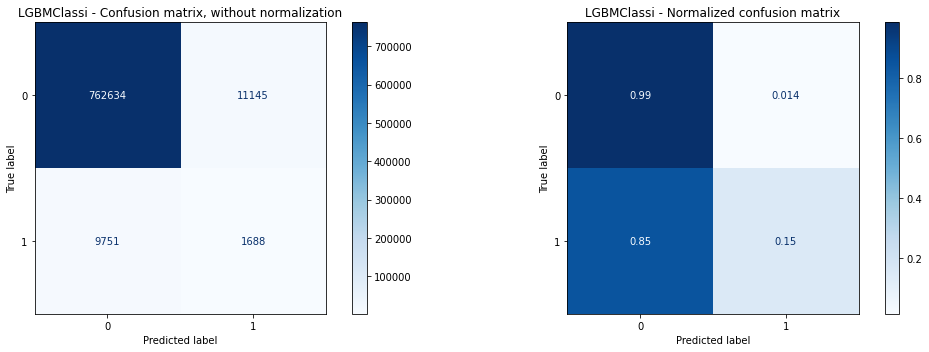

In [48]:
for model in df_res['model']:
    dame_matrices(model)

Las matrices de confusión muestran en general, una tasa muy alta de falsos negativos. Es decir la clase minoritaria no está siendo predecida correctamente. 

A continuación, antes de decidir el modelo ganador procederemos a analizar otras métricas para cada modelo:

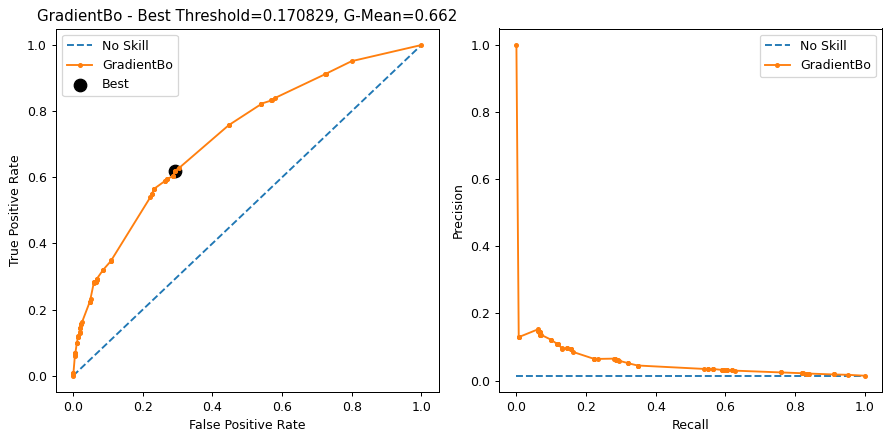

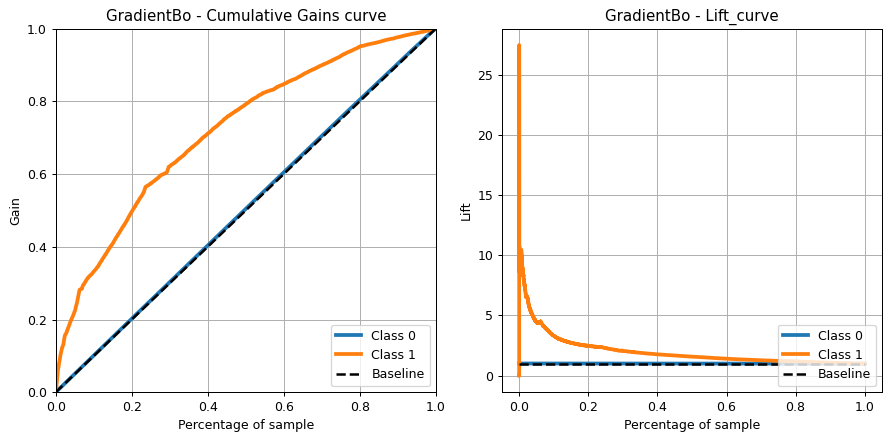

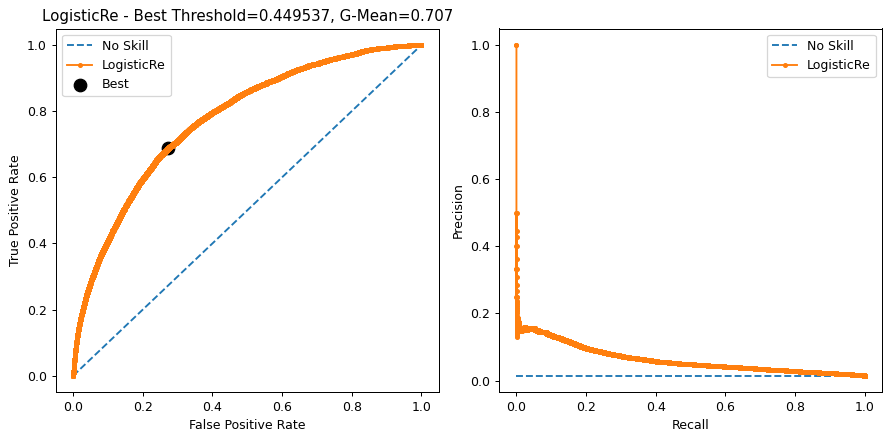

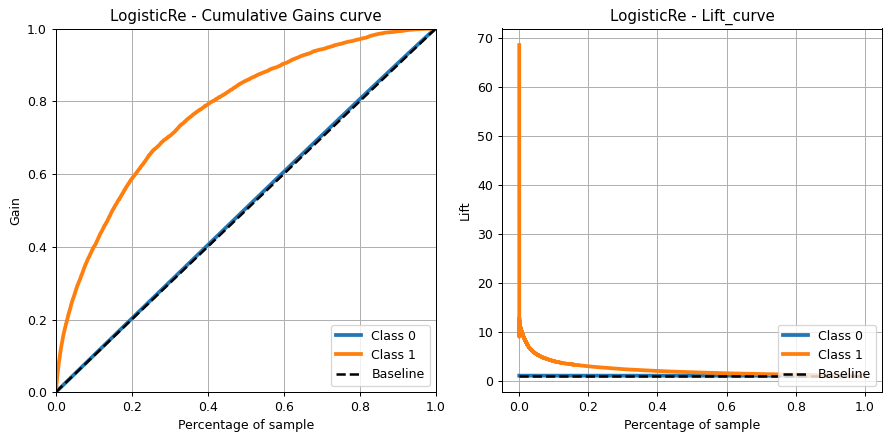

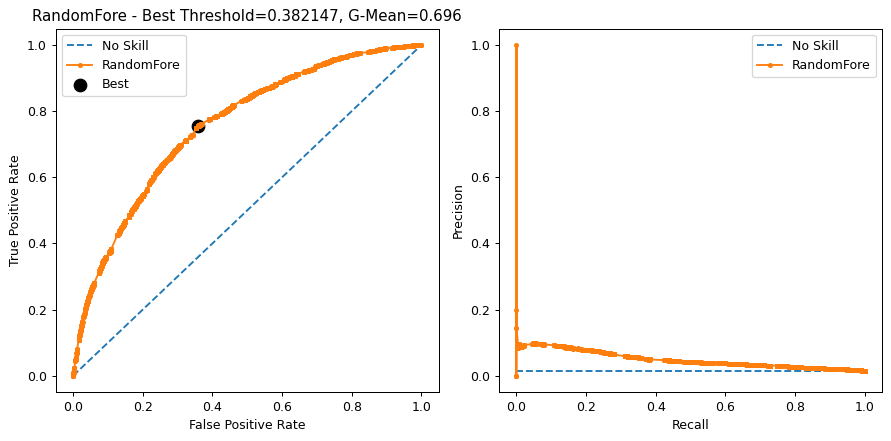

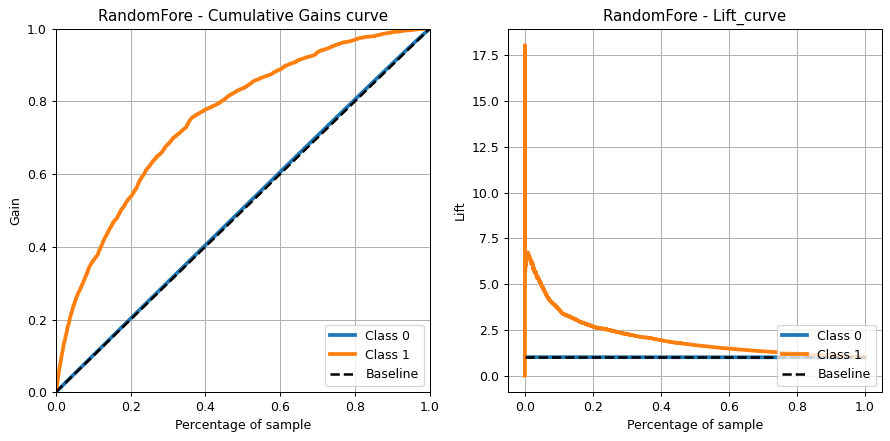

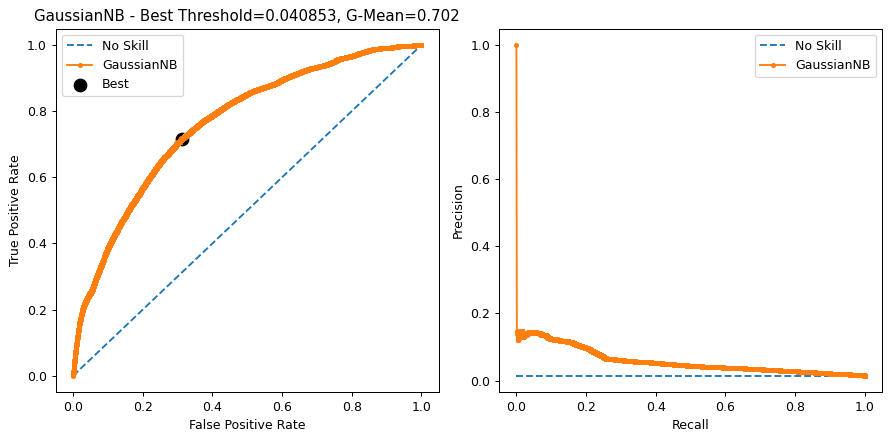

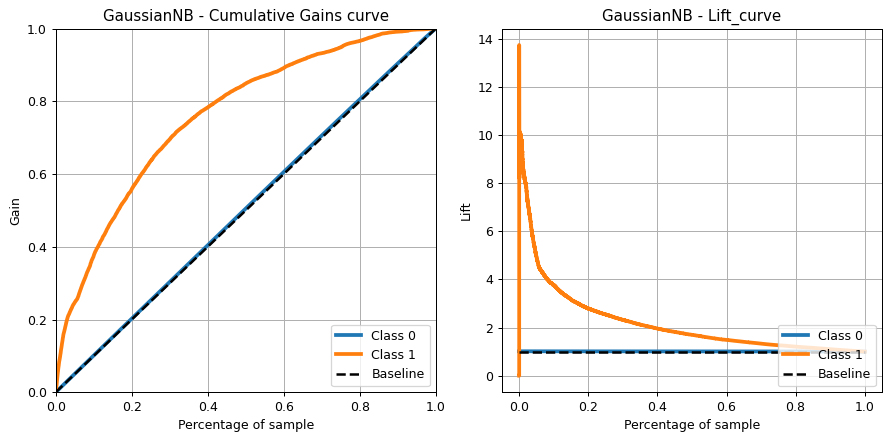

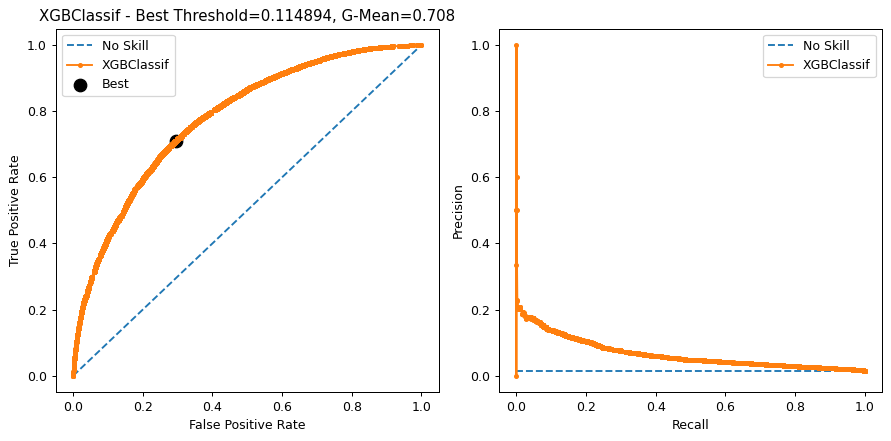

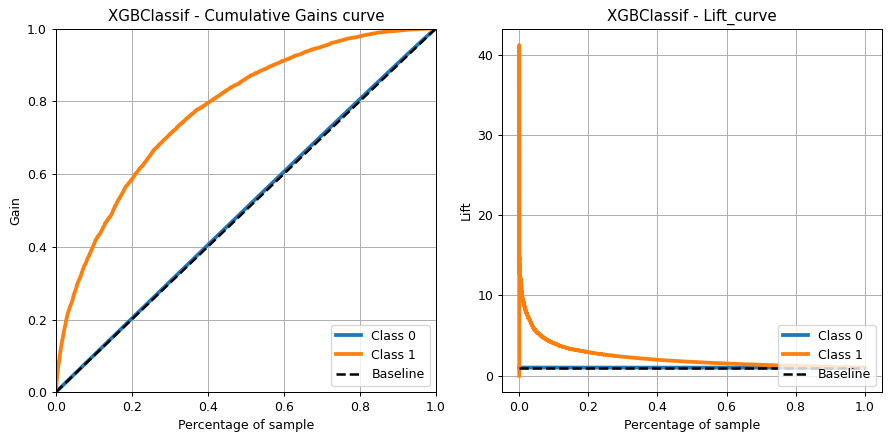

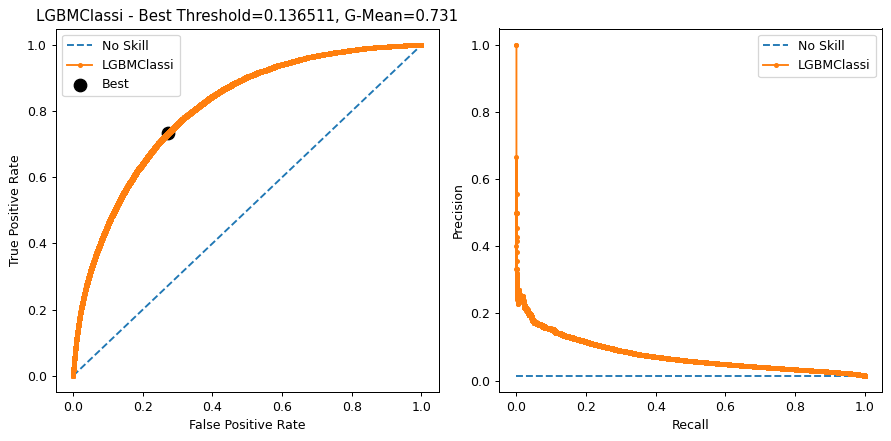

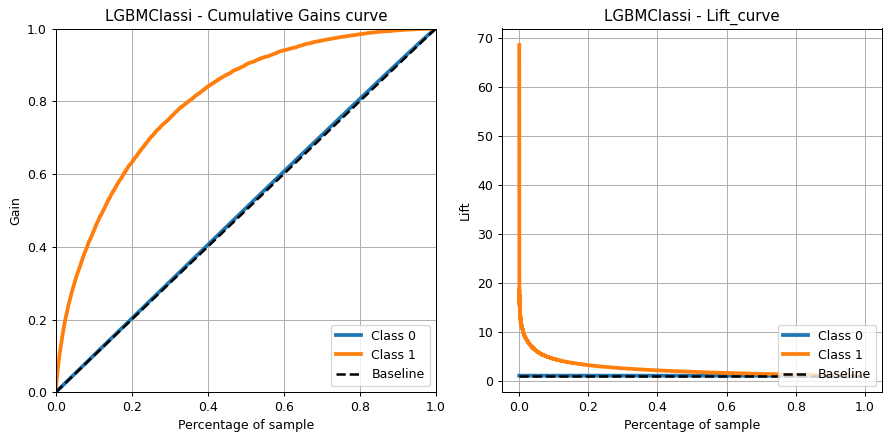

In [51]:
for model in df_res['model']:
    dame_curvas(model)

Si observamos la curva de ganancia podemos apreciar la capicidad del modelo de predecir la variable target según el tamaño de la muestra. En este sentido si observamos la curva de ganancia del modelo LGBM Classifier, sería el que tiene más capacidad de predicción ya que con un 60% de la muestra es capaz de predecir casi el 95% de la variable target. Es muy importante esta métrica porque se pude ver desde el punto de vista de la empresa el esfuerzo que tiene que realizar para capturar la clase minoritaria. 

Analizando la curva lift, podemos observar el poder predictivo del modelo en comparación con no usarlo. En este sentido, un modelo será mejor que otro si la curva lift tiene un levantamiento mayor. En nuestro caso los mejores modelos según la curva lift serían el Logistic Regression y el LGBM Classifier.

A continuación procederemos a cambiar el threshold según el punto de optimización de la curva ROC y generaremos las correspondientes matrices de confusion con el threshold optimizado para cada modelo:

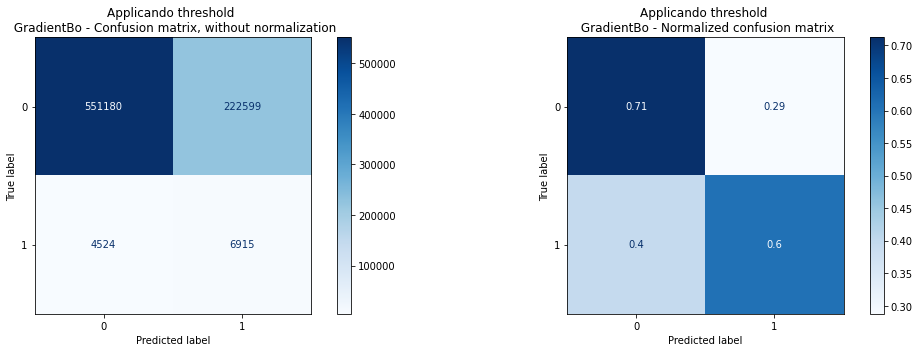

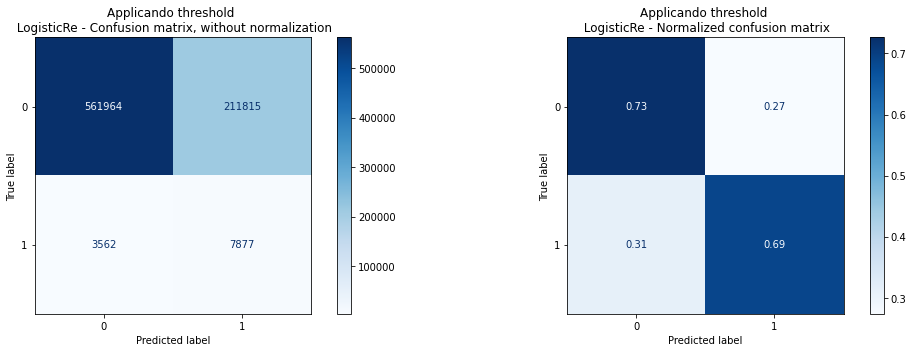

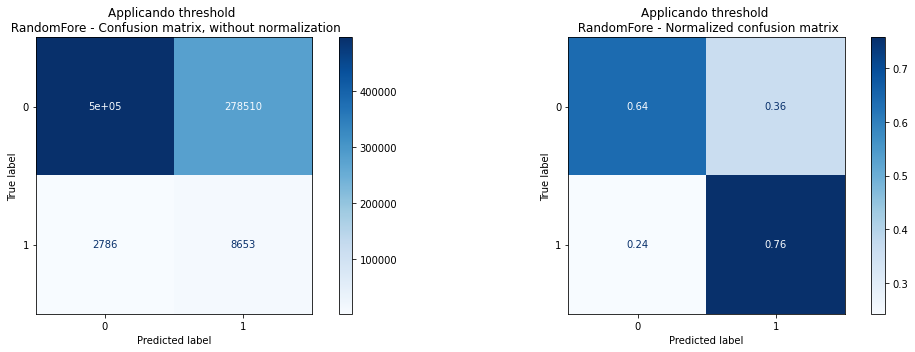

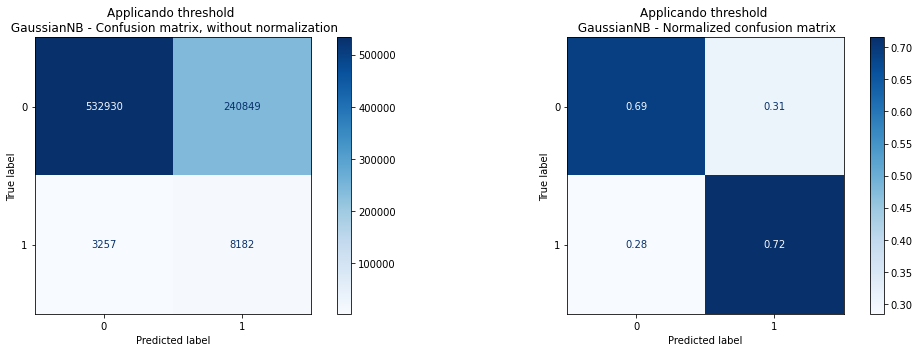

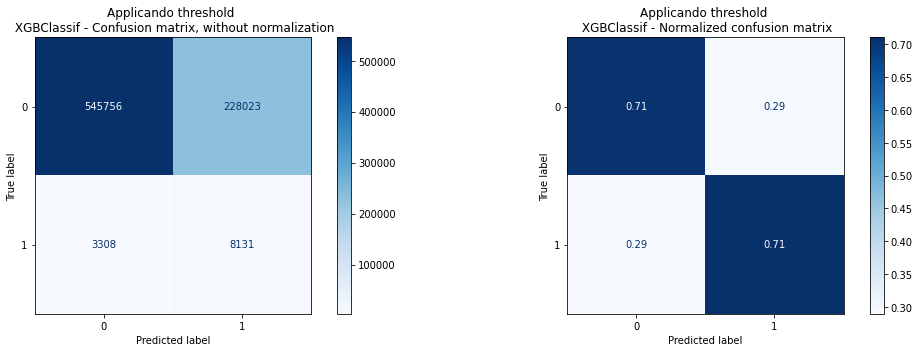

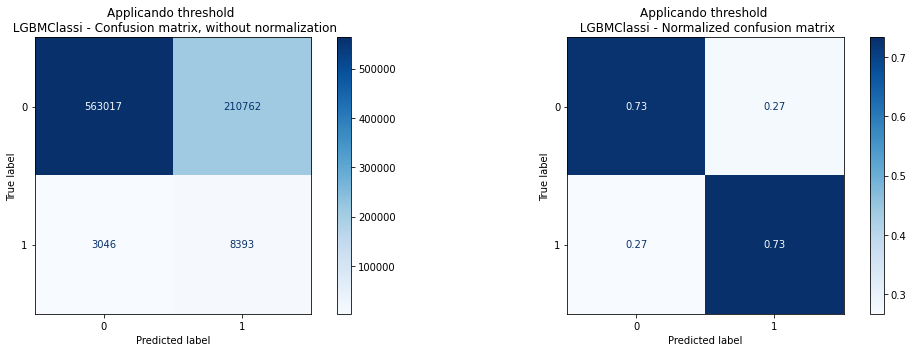

In [52]:
for model in df_res['model']:
    matrices_threshold(model)

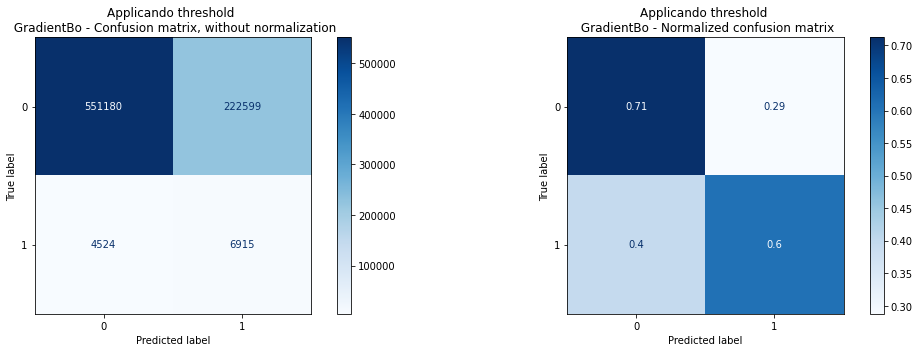

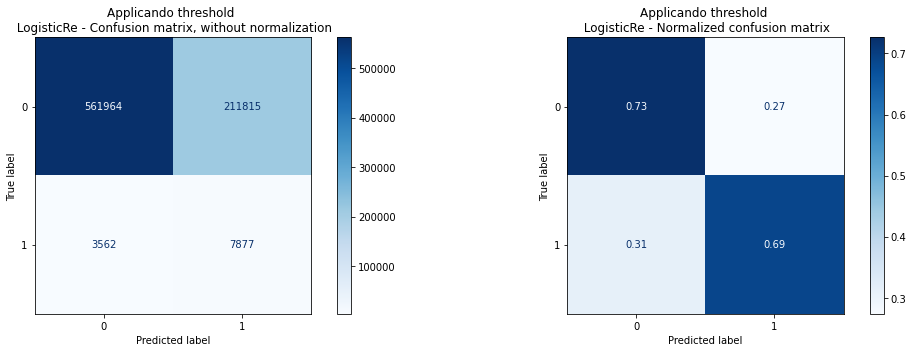

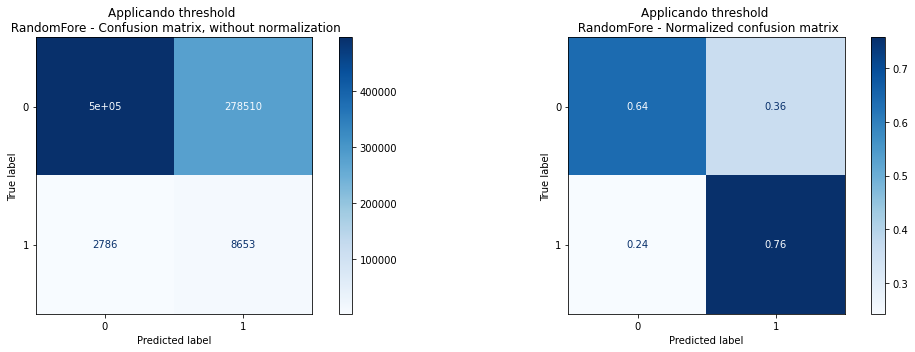

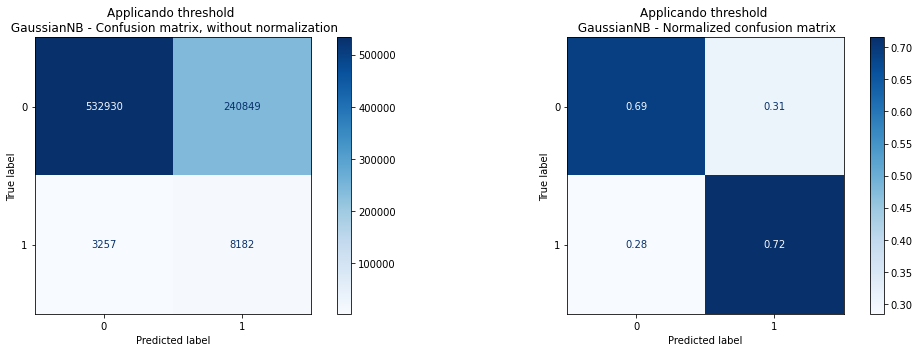

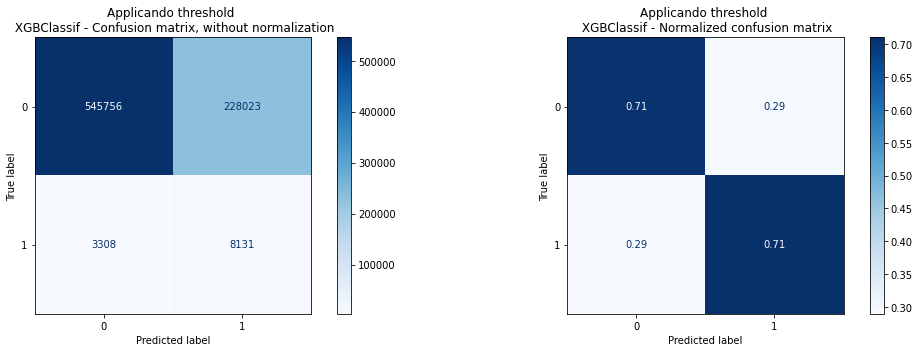

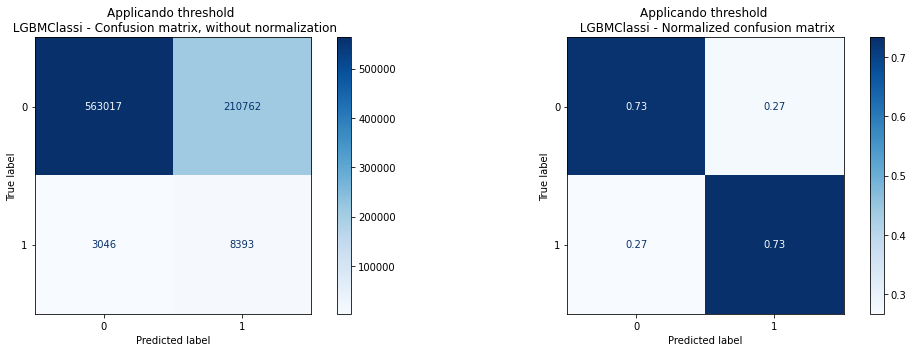

In [52]:
for model in df_res['model']:
    evaluate_model(y_test, predictions1, lgb_pred_proba1)(model)

Finalmente vamos a proceder con la optimización del modelo ganador que en nuestro caso, teniendo en cuenta todas las metricas analizadas con anterioridad más el coste computacional que conlleva la ejecución de los mismos, sería el LGBM Classifier.